# Rock · Paper · Scissors — Data Exploration & Split

In [1]:
# --------------------------------------------
# 00-setup → Path configuration & auto-reload
# --------------------------------------------

# Auto-reload enabled for notebook development
%load_ext autoreload
%autoreload 2

# Standard libraries
import os
import sys
from pathlib import Path
from collections import defaultdict

# Third-party libraries
import numpy as np
import pandas as pd
import imagehash
from PIL import Image
from sklearn.model_selection import (
    cross_val_score,
    cross_validate,
    RandomizedSearchCV
)
from sklearn.metrics import classification_report
from scikeras.wrappers import KerasClassifier
from tensorflow.keras import layers, optimizers, initializers, Model

# -------------------------------------------------
# Path Setup: Add project root and `src/` to sys.path
# -------------------------------------------------

proj_root = Path("..").resolve()              # Parent of /notebooks → /ml-rps
src_path = proj_root / "src"

for path in [proj_root, src_path]:
    if str(path) not in sys.path:
        sys.path.append(str(path))

print("✔ Path configuration updated:")
print(f"  proj_root: {proj_root}")
print(f"  src_path : {src_path}")

# --------------------------------------------
# Import internal project modules
# --------------------------------------------

from src import utils, eda
import importlib
import src.model4 as model4
importlib.reload(model4)


✔ Path configuration updated:
  proj_root: /Users/cihanelv/Desktop/ml-rps
  src_path : /Users/cihanelv/Desktop/ml-rps/src


<module 'src.model4' from '/Users/cihanelv/Desktop/ml-rps/src/model4.py'>

## 1. Initial Look at the Raw Data
Task: View the number of files per class and sample images.

RAW DATA OVERVIEW
  rock    : 726 images
  paper   : 712 images
  scissors: 750 images

Sample image size: (300, 200)  (width, height)
  Figure saved ➜ /Users/cihanelv/Desktop/ml-rps/figures/raw_samples_20250704T010044.png


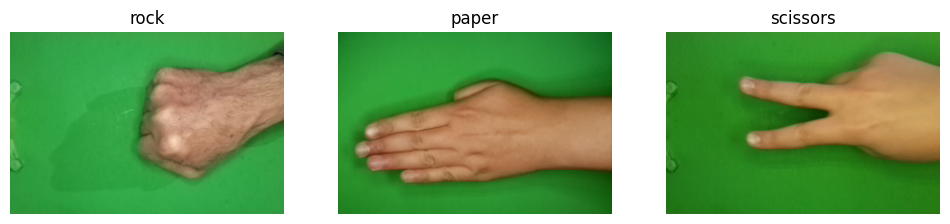

All images have the same size: (300, 200)

RAW DATA COUNTS
  rock    : 726 images
  paper   : 712 images
  scissors: 750 images

  Figure saved ➜ /Users/cihanelv/Desktop/ml-rps/figures/raw_counts_20250704T010045.png


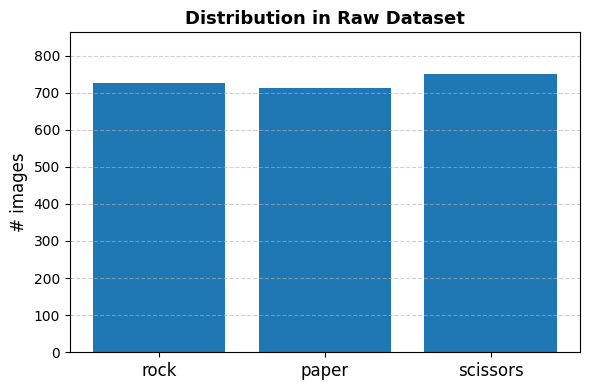

In [ ]:
from src import eda

# 1-a) Class counts + sample images
eda.raw_overview(raw_dir="../data_raw/archive")

# 1-b) Ensure all .png files have the same dimensions
eda.check_raw_sizes(raw_dir="../data_raw/archive")

# 1-c) Plot raw data distribution
eda.plot_raw_counts(
    raw_dir="../data_raw/archive",
    fig_dir="figures"     # Plot will be saved in this folder (PNG)
)


## 2. Stratified Train/Validation/Test Split
We split the data into 64% train, 16% validation, and 20% test sets.

Directory ../data_split already exists; skipping split.

SPLIT COUNTS
  train {'rock': 465, 'paper': 455, 'scissors': 480}
  val   {'rock': 116, 'paper': 114, 'scissors': 120}
  test  {'rock': 145, 'paper': 143, 'scissors': 150}

  Figure saved ➜ /Users/cihanelv/Desktop/ml-rps/figures/split_counts_20250704T010045.png


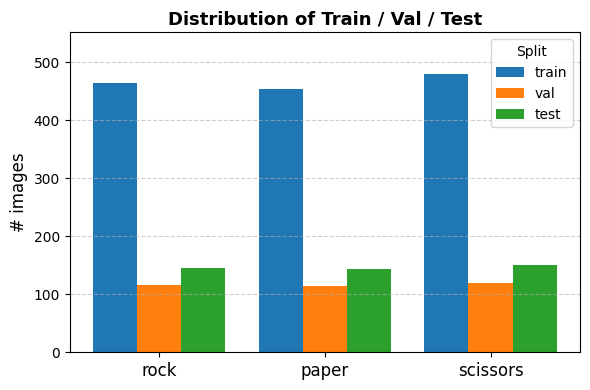

In [3]:
# 2-a) Create folders + copy files
eda.split_data(
    raw_dir="../data_raw/archive",
    split_dir="../data_split",
    seed=42                    # reproducibility
)

# 2-b) Visualize the distribution with a bar chart
eda.plot_split_counts(
    split_dir="../data_split",
    fig_dir="figures"          # PNGs will be saved in this folder
)

In [4]:
# 03 | Generators 
train_gen, val_gen, test_gen = eda.build_generators(
    split_dir = "../data_split",
    img_size  = (150, 100),
    batch     = 32,
    seed      = 42
)

# 04 | Fast Distribition Control
eda.generator_stats(train_gen, val_gen, test_gen)

Found 1400 images belonging to 3 classes.
Found 350 images belonging to 3 classes.
Found 438 images belonging to 3 classes.
GENERATOR CLASS COUNTS
  Train: {'paper': 455, 'rock': 465, 'scissors': 480}
  Val  : {'paper': 114, 'rock': 116, 'scissors': 120}
  Test : {'paper': 143, 'rock': 145, 'scissors': 150}

OVERALL COUNTS
  train: 1400 images (64.0 %)
  val  :  350 images (16.0 %)
  test :  438 images (20.0 %)

Total images: 2188



Found 1400 images belonging to 3 classes.


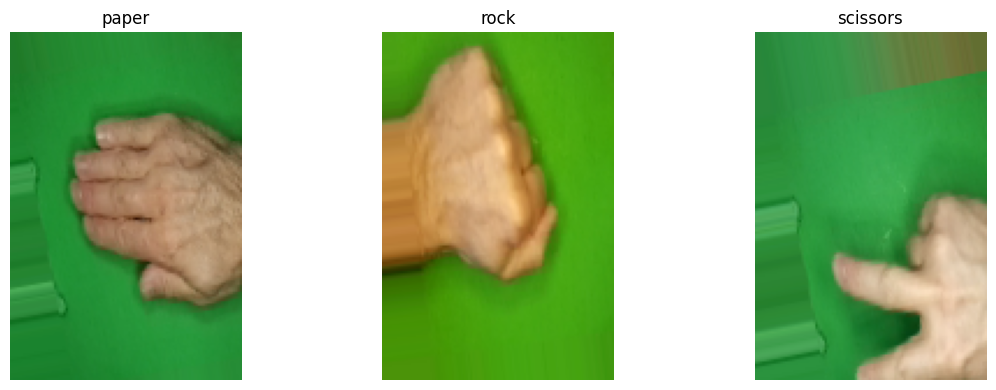

In [5]:
# 05 | Augmented samples --------------------------------------------------
# Show & save one augmented sample per class, in the exact class_indices order
eda.show_augmented_samples(
    train_gen,
    save_path="figures/augmented_samples.png",
    seed=42
)

## Starting the Models

In [6]:
import importlib, src.model4 as model4
importlib.reload(model4)

<module 'src.model4' from '/Users/cihanelv/Desktop/ml-rps/src/model4.py'>

In [7]:
# ===========================================================================
# PART 1: ROBUST TOPOLOGY COMPARISON WITH CROSS-VALIDATION
# ===========================================================================
print("\n" + "─" * 70)
print("PART 1: COMPARING BASELINE ARCHITECTURES (WITH 5-FOLD CROSS-VALIDATION)")
print("─" * 70)

# 1. Prepare Data Generators
train_gen, val_gen, test_gen = eda.build_generators(
    split_dir="../data_split", img_size=(150, 100), batch=32, seed=42
)

# 2. Define specific configurations for a fair comparison
comparison_configs = {
    "1-Basic": {"blocks": 1, "filters": [8], "dense_units": 16, "dropout_rate": 0.0, "lr": 1e-3, "use_batch_norm": False, "kernel_size": 3, "pooling_method": 'max'},
    "2-Intermediate": {"blocks": 2, "filters": [32, 64], "dense_units": 64, "dropout_rate": 0.2, "lr": 1e-3, "use_batch_norm": False, "kernel_size": 3, "pooling_method": 'max'},
    "3-Complex (No BN)": {"blocks": 3, "filters": [32, 64, 128], "dense_units": 128, "dropout_rate": 0.3, "lr": 1e-3, "use_batch_norm": False, "kernel_size": 3, "pooling_method": 'max'},
    #"4-Complex (With BN)": {"blocks": 3, "filters": [32, 64, 128], "dense_units": 512, "dropout_rate": 0.4, "lr": 1e-3, "use_batch_norm": True, "kernel_size": 3, "pooling_method": 'max'},
}

# 3. Load full training data into memory for cross-validation
print("Loading training data into memory for CV...")
X_train, y_train = [], []
for i in range(len(train_gen)):
    x_batch, y_batch = train_gen[i]
    X_train.append(x_batch)
    y_train.append(y_batch)
X_train = np.concatenate(X_train)
y_train = np.concatenate(y_train)

# 4. Evaluate each configuration using 3-fold cross-validation
all_records_cv = []
for name, params in comparison_configs.items():
    print(f"\n--- Running CV for: {name} ---")
    estimator = KerasClassifier(
        model=model4.create_model, epochs=25, batch_size=32, verbose=0, **params
    )
    scores = cross_val_score(estimator, X_train, y_train, cv=3, scoring='accuracy')
    all_records_cv.append({
        "Model": name,
        "Mean CV Acc": round(scores.mean(), 4),
        "Std Dev Acc": round(scores.std(), 4),
    })

# 5. Display comparison results
df_comparison_cv = pd.DataFrame(all_records_cv)
df_sorted_cv = df_comparison_cv.sort_values(by="Mean CV Acc", ascending=False)
print("\n\n" + "─" * 70)
print("CROSS-VALIDATED TOPOLOGY COMPARISON RESULTS")
print("─" * 70)
print(df_sorted_cv.to_string(index=False))


──────────────────────────────────────────────────────────────────────
PART 1: COMPARING BASELINE ARCHITECTURES (WITH 5-FOLD CROSS-VALIDATION)
──────────────────────────────────────────────────────────────────────
Found 1400 images belonging to 3 classes.
Found 350 images belonging to 3 classes.
Found 438 images belonging to 3 classes.
Loading training data into memory for CV...

--- Running CV for: 1-Basic ---


2025-07-04 03:00:49.853003: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2
2025-07-04 03:00:49.853036: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 24.00 GB
2025-07-04 03:00:49.853040: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 8.00 GB
2025-07-04 03:00:49.853059: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-07-04 03:00:49.853072: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2025-07-04 03:00:50.305718: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.



--- Running CV for: 2-Intermediate ---

--- Running CV for: 3-Complex (No BN) ---


──────────────────────────────────────────────────────────────────────
CROSS-VALIDATED TOPOLOGY COMPARISON RESULTS
──────────────────────────────────────────────────────────────────────
            Model  Mean CV Acc  Std Dev Acc
3-Complex (No BN)       0.8108       0.0495
   2-Intermediate       0.6343       0.1212
          1-Basic       0.4443       0.0364


In [8]:
# ===========================================================================
# PART 2: FOCUSED HYPERPARAMETER TUNING & FINAL EVALUATION
# ===========================================================================
print("\n" + "─" * 70)
print("PART 2: HYPERPARAMETER TUNING ON BEST ARCHITECTURE")
print("─" * 70)

# 1. Define the Keras Model Creation Function LOCALLY to avoid cloning errors
def create_model_local(blocks: int, filters: list, dense_units: int, dropout_rate: float,
                       lr: float, kernel_size: int, use_batch_norm: bool, pooling_method: str,
                       seed: int = 42) -> Model:
    """Builds and compiles a CNN model for the search."""
    utils.seed_everything(seed)
    init = initializers.GlorotUniform(seed=seed)
    img_input = layers.Input(shape=(150, 100, 3))
    x = img_input
    for f in filters:
        if use_batch_norm:
            x = layers.Conv2D(f, kernel_size, padding="same", use_bias=False, kernel_initializer=init)(x)
            x = layers.BatchNormalization()(x)
            x = layers.Activation("relu")(x)
        else:
            x = layers.Conv2D(f, kernel_size, padding="same", activation="relu", kernel_initializer=init)(x)
        x = layers.MaxPooling2D(2)(x)
    x = layers.Flatten()(x)
    x = layers.Dense(dense_units, activation="relu", kernel_initializer=init)(x)
    if dropout_rate > 0:
        x = layers.Dropout(dropout_rate, seed=seed)(x)
    output = layers.Dense(3, activation="softmax", kernel_initializer=init)(x)
    model = Model(inputs=img_input, outputs=output)
    model.compile(optimizer=optimizers.Adam(learning_rate=lr),
                  loss="categorical_crossentropy", metrics=["accuracy"])
    return model

# 2. Define Expanded Hyperparameter Search Space
# All parameter names must be prefixed with "model__"
param_dist = {
    'model__lr': [1e-3, 1e-4],
    'model__filters': [[16, 32], [32, 64]],
    'model__dense_units': [64, 128, 256],
    'model__dropout_rate': [0.2, 0.3],
    'model__kernel_size': [3, 5],
    'model__blocks': [2],
    'model__use_batch_norm': [False],
    'model__pooling_method': ['max']
}

# 3. Set Up and Run the Automated Search
keras_model = KerasClassifier(model=create_model_local, verbose=0)
random_search = RandomizedSearchCV(
    estimator=keras_model,
    param_distributions=param_dist,
    n_iter=20, # Number of random combinations to try
    cv=5,
    scoring='accuracy',
    verbose=2,
    random_state=42
)

# 4. Run the search on the training data, passing fit parameters
print(f"\nSTARTING RANDOMIZED HYPERPARAMETER SEARCH (n_iter={random_search.n_iter}, cv={random_search.cv})...")
random_search.fit(X_train, y_train, epochs=20, batch_size=64)

# 5. Display Search Results
print("\n\n" + "─" * 70)
print("RANDOMIZED SEARCH COMPLETE")
print("─" * 70)
print(f"Best Validation Accuracy (from CV): {random_search.best_score_:.4f}")
print("Best Hyperparameters Found:")
print(random_search.best_params_)

# 6. Train and Evaluate the Final Champion Model
print("\n\n" + "─" * 70)
print("TRAINING FINAL CHAMPION MODEL WITH BEST PARAMETERS...")
print("The learning curves for this final model will be plotted below.")
print("─" * 70)
# Create a new dictionary for the final parameters without the "model__" prefix
final_params = {k.replace('model__', ''): v for k, v in random_search.best_params_.items()}
final_history, final_model = model4.train(
    train_gen, val_gen, epochs=40, batch_size=32, **final_params
)

# 7. Final Evaluation on the Unseen Test Set
print("\n\n" + "─" * 70)
print("FINAL EVALUATION ON THE UNSEEN TEST SET")
print("─" * 70)
y_pred = final_model.predict(test_gen)
y_pred_classes = np.argmax(y_pred, axis=1)
print(classification_report(
    test_gen.classes, y_pred_classes, target_names=test_gen.class_indices.keys()
))


──────────────────────────────────────────────────────────────────────
PART 2: HYPERPARAMETER TUNING ON BEST ARCHITECTURE
──────────────────────────────────────────────────────────────────────

STARTING RANDOMIZED HYPERPARAMETER SEARCH (n_iter=20, cv=5)...
Fitting 5 folds for each of 20 candidates, totalling 100 fits
[CV] END model__blocks=2, model__dense_units=128, model__dropout_rate=0.3, model__filters=[16, 32], model__kernel_size=5, model__lr=0.0001, model__pooling_method=max, model__use_batch_norm=False; total time=  26.1s
[CV] END model__blocks=2, model__dense_units=128, model__dropout_rate=0.3, model__filters=[16, 32], model__kernel_size=5, model__lr=0.0001, model__pooling_method=max, model__use_batch_norm=False; total time=  26.6s
[CV] END model__blocks=2, model__dense_units=128, model__dropout_rate=0.3, model__filters=[16, 32], model__kernel_size=5, model__lr=0.0001, model__pooling_method=max, model__use_batch_norm=False; total time=  26.7s
[CV] END model__blocks=2, model__de

/Users/cihanelv/Desktop/ml-rps/rpsenv/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


44/44 ━━━━━━━━━━━━━━━━━━━━ 11s 210ms/step - accuracy: 0.3527 - loss: 1.3280 - val_accuracy: 0.5286 - val_loss: 1.0744
Epoch 2/40
44/44 ━━━━━━━━━━━━━━━━━━━━ 8s 183ms/step - accuracy: 0.4295 - loss: 1.0671 - val_accuracy: 0.5743 - val_loss: 0.9551
Epoch 3/40
44/44 ━━━━━━━━━━━━━━━━━━━━ 8s 185ms/step - accuracy: 0.4719 - loss: 1.0215 - val_accuracy: 0.7400 - val_loss: 0.8936
Epoch 4/40
44/44 ━━━━━━━━━━━━━━━━━━━━ 8s 182ms/step - accuracy: 0.5513 - loss: 0.9537 - val_accuracy: 0.7714 - val_loss: 0.7842
Epoch 5/40
44/44 ━━━━━━━━━━━━━━━━━━━━ 8s 182ms/step - accuracy: 0.6387 - loss: 0.8732 - val_accuracy: 0.8829 - val_loss: 0.6230
Epoch 6/40
44/44 ━━━━━━━━━━━━━━━━━━━━ 8s 182ms/step - accuracy: 0.7138 - loss: 0.7321 - val_accuracy: 0.9000 - val_loss: 0.4955
Epoch 7/40
44/44 ━━━━━━━━━━━━━━━━━━━━ 8s 190ms/step - accuracy: 0.7485 - loss: 0.6569 - val_accuracy: 0.8943 - val_loss: 0.4604
Epoch 8/40
44/44 ━━━━━━━━━━━━━━━━━━━━ 8s 180ms/step - accuracy: 0.7419 - loss: 0.6231 - val_accuracy: 0.8229 - val

In [9]:
# Train–Test pHash overlap
from pathlib import Path, PurePosixPath
import imagehash
from PIL import Image


def hash_dict(folder):
    """
    Return a dictionary mapping perceptual hashes to the PNG file names
    found recursively under *folder*.
    """
    d = {}
    for p in Path(folder).rglob("*.png"):
        h = str(imagehash.phash(Image.open(p)))
        d.setdefault(h, []).append(PurePosixPath(p).name)
    return d


# Compute the intersection of hashes between training and test sets
leaks = set(hash_dict("../data_split/train")) & set(hash_dict("../data_split/test"))
print("Hash collisions between train and test:", len(leaks))  # Expected: 0


Hash collisions between train and test: 2




──────────────────────────────────────────────────────────────────────
FINAL EVALUATION AND ANALYSIS ON THE UNSEEN TEST SET
──────────────────────────────────────────────────────────────────────
Evaluating the final model on the test set...
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - accuracy: 0.9653 - loss: 0.1412

Final Test Loss:      0.1020
Final Test Accuracy:  0.9795

Generating predictions for the classification report...
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step

Classification Report on the Test Set
              precision    recall  f1-score   support

       paper       0.99      0.95      0.97       143
        rock       0.98      1.00      0.99       145
    scissors       0.97      0.99      0.98       150

    accuracy                           0.98       438
   macro avg       0.98      0.98      0.98       438
weighted avg       0.98      0.98      0.98       438


──────────────────────────────────────────────────────────────────────
VISUALISING MISCLASSIFIED EXAMPLES


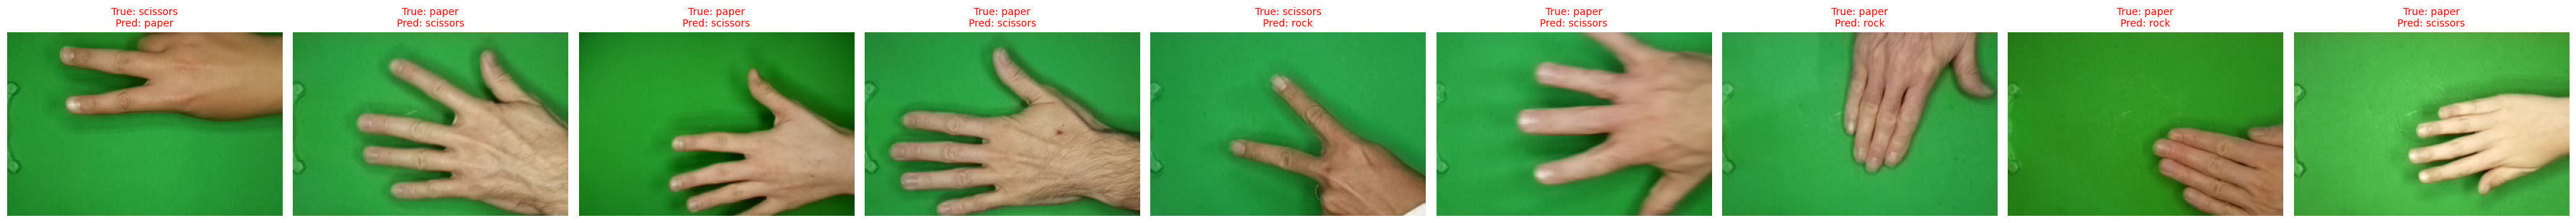



──────────────────────────────────────────────────────────────────────
TRAINING CURVES FOR OVERFITTING AND UNDERFITTING ANALYSIS
──────────────────────────────────────────────────────────────────────
  Figure saved ➜ /Users/cihanelv/Desktop/ml-rps/figures/final_selected_model_curves_20250704T020248.png


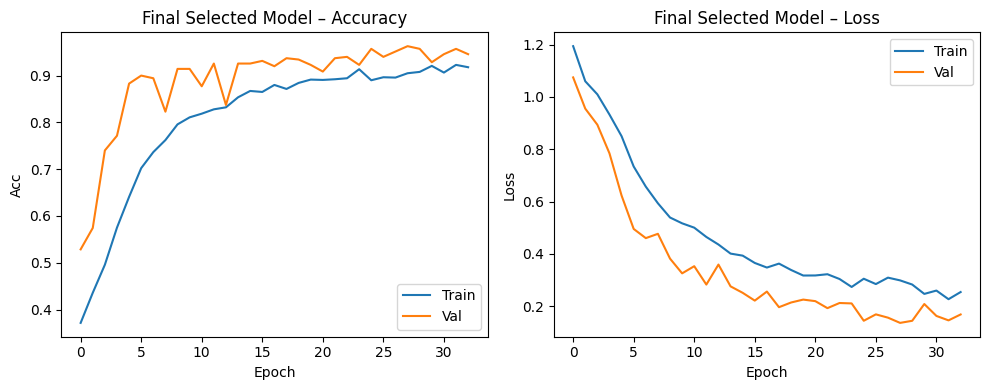


The accuracy and loss curves above provide a basis for discussing possible overfitting or underfitting.



In [10]:
import numpy as np
import matplotlib.pyplot as plt
import os
from PIL import Image
from sklearn.metrics import classification_report

# If not already in memory, import project utilities and the trained model
# import src.utils as utils
# import src.model4 as model4

# ===========================================================================
# 6. Evaluation and Analysis
# ===========================================================================
print("\n\n" + "─" * 70)
print("FINAL EVALUATION AND ANALYSIS ON THE UNSEEN TEST SET")
print("─" * 70)

# ---------------------------------------------------------------------------
# Evaluate final model on the test set
# ---------------------------------------------------------------------------
print("Evaluating the final model on the test set...")
test_loss, test_accuracy = final_model.evaluate(test_gen, verbose=1)

print(f"\nFinal Test Loss:      {test_loss:.4f}")
print(f"Final Test Accuracy:  {test_accuracy:.4f}")

# ---------------------------------------------------------------------------
# Generate classification report
# ---------------------------------------------------------------------------
print("\nGenerating predictions for the classification report...")
y_pred = final_model.predict(test_gen)
y_pred_classes = np.argmax(y_pred, axis=1)

true_labels = test_gen.classes

print("\nClassification Report on the Test Set")
print(classification_report(
    true_labels,
    y_pred_classes,
    target_names=test_gen.class_indices.keys()
))

# ===========================================================================
# Visualising Misclassified Examples
# ===========================================================================
print("\n" + "─" * 70)
print("VISUALISING MISCLASSIFIED EXAMPLES")
print("─" * 70)

# ---------------------------------------------------------------------------
# Ensure deterministic sampling of misclassified indices
# ---------------------------------------------------------------------------
SEED = 42
utils.seed_everything(SEED)

# Identify misclassifications
misclassified_indices = np.where(true_labels != y_pred_classes)[0]
print(f"Total misclassified examples: {len(misclassified_indices)}")

if len(misclassified_indices) == 0:
    print("No misclassified examples to display. The model achieved perfect classification on the test set.")
else:
    idx_to_class = {v: k for k, v in test_gen.class_indices.items()}

    # Select up to 10 examples in a reproducible manner
    num_to_show = min(len(misclassified_indices), 10)
    display_indices = np.random.choice(
        misclassified_indices,
        num_to_show,
        replace=False
    )

    fig, axes = plt.subplots(1, num_to_show, figsize=(4 * num_to_show, 4))
    if num_to_show == 1:
        axes = [axes]

    print(f"Displaying {num_to_show} misclassified example(s):")
    for i, idx in enumerate(display_indices):
        file_name = test_gen.filenames[idx]
        full_image_path = os.path.join(test_gen.directory, file_name)

        true_class_name = idx_to_class[true_labels[idx]]
        predicted_class_name = idx_to_class[y_pred_classes[idx]]

        img = Image.open(full_image_path)
        axes[i].imshow(img)
        axes[i].set_title(
            f"True: {true_class_name}\nPred: {predicted_class_name}",
            color="red",
            fontsize=10
        )
        axes[i].axis("off")

    plt.tight_layout()
    utils.save_fig(fig, "misclassified_examples", "figures")
    plt.show()

# ===========================================================================
# 7. Training Curves: Overfitting and Underfitting
# ===========================================================================
print("\n\n" + "─" * 70)
print("TRAINING CURVES FOR OVERFITTING AND UNDERFITTING ANALYSIS")
print("─" * 70)

utils.plot_training_curves(
    final_history,
    title_prefix="Final Selected Model",
    save_png=True,
    folder="figures"
)

print("\nThe accuracy and loss curves above provide a basis for discussing possible overfitting or underfitting.\n")


  Figure saved ➜ /Users/cihanelv/Desktop/ml-rps/figures/confusion_matrix_20250704T020248.png


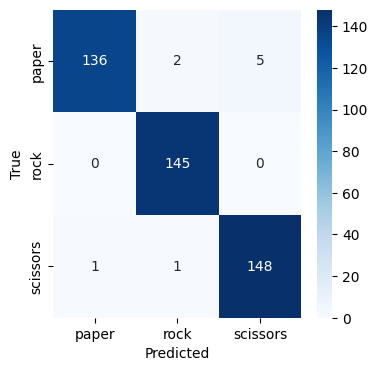

In [11]:
from sklearn.metrics import confusion_matrix
import seaborn as sns  # veya saf matplotlib
cm = confusion_matrix(true_labels, y_pred_classes)
plt.figure(figsize=(4,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=test_gen.class_indices.keys(),
            yticklabels=test_gen.class_indices.keys())
plt.xlabel('Predicted'); plt.ylabel('True')
utils.save_fig(plt.gcf(), "confusion_matrix", "figures")
plt.show()
